# Model Designation

Primary task of the use-case is to explore the of usage of feature enginnering methods, for improvement of the accuracy and quality of predictions of ML models for solving regression tasks. Therefore, having in mind that the emphasis is not on model development, but on feature engineering, model designation is of secondary importances. For the purposes of the use-case, a linear regression model will be fitted.

# Objective of Learning Task

The objective of the use-case is to fit, deploy, and examine effectiveness of feature engineering methods for the purposes of improving accuracy and quality of fit of linear regression model. Accurcy will be measured as Mean Absolute Error (MAE) and quality of fit will be measured as squared correlation coefficient between targets and predictions (Kuhn M., Kjell, J., Applied Predictive Modeling, 2013). 

# Technology Stack

Python programing language has been selected for the purposes of model development. Virtualenv package is utilized for generation of specific environment. Feature engineering is done within Skelarn, and computatuin is done with Intel's MKL as the LAPACK/BLAS computational backend. Data manitpulation is mostly done in numpy because there is there is no pronunced need to use named feature and target vectors. Usage of these technologies is encouraged in order to get repodocuible results.

# Methodology of Feature Engineering

Feature engineering methodology consisst of following phases.

- Fit feature engineering method
- Produce engineered features.
- Standardize engineered features (not necessary in the case of k-bins dihotomization).
- Fit linear regression model.

This is repeated for all feature engineering methods used. Prior to fitting, original features are standardized. (In total, features are standardized twice; once before and once after engineering.) After production of data set with engineered features, linear model is fitted and predictions are generated out of this data set. Prerformance of model obtained from data set with enginered features, is then compared to the performance of the model fitted on original (un-engineered) features.

# Feature Engineering

First step is to import necessary packages.

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Now, we proceed with declaration of a class for data holding the names of the features and targets. This class also preforms basic data preparation, hence the name of the class. However, further preparation of the data is performed downstream as well.

In [2]:
class PreparedData:
    def __init__(self, inn):
        self.original_data = inn
        self.prepared_data = None
        self.feature_labels = None
        self.target_labels = None
        # Assign index and convert to date.
        out = inn.copy(deep=True)
        out.index = pd.to_datetime(inn['date'])
        # Drop unnecessary columns.
        out.drop(columns=['date', 'rv1', 'rv2'], inplace=True)
        # Get labels.
        target_labels = [
            label for label in inn.columns if
            ('T1' in label)
            & ('_out' not in label)
            & ('Tdewpoint' not in label)
        ]
        feature_labels = set(out.columns) - set(target_labels)
        self.prepared_data = out
        self.feature_labels = feature_labels
        self.target_labels = target_labels

The purpose of the following function is to create a subset of data by selecting desired columns.

In [3]:
def subset_columns(frame, columns):
    """
    Return numpy array wh. subset of columns.
    """
    return np.array(frame.loc[:, columns])

Previous function is then followed with two utility functions. One, to make feature data sets.

In [4]:
def make_features(training_frame,
                  validation_frame,
                  testing_frame,
                  feature_columns):
    """
    Return a features for training, validation, and testing.
    """
    return (
        subset_columns(
            frame=training_frame,
            columns=feature_columns,
        ),
        subset_columns(
            frame=validation_frame,
            columns=feature_columns,
        ),
        subset_columns(
            frame=testing_frame,
            columns=feature_columns
        )
    )

And another to make targets data sets.

In [5]:
def make_targets(training_frame,
                 validation_frame,
                 testing_frame,
                 targets_columns):
    """
    Return a features for training, validation, and testing.
    """
    return (
        subset_columns(
            frame=training_frame,
            columns=targets_columns,
        ),
        subset_columns(
            frame=validation_frame,
            columns=targets_columns,
        ),
        subset_columns(
            frame=testing_frame,
            columns=targets_columns
        )
    )

Now we move on to the hart of the project. We will declare a function to return various feature engineering methods.

In [6]:
def get_feature_engineering_methods():
    """
    Return dictionary wh. feature engineering methods.
    """
    return OrderedDict([
        (
            'quantile_transformer',
            QuantileTransformer(
                n_quantiles=50,
                output_distribution='normal',
                random_state=0,
                copy=True
            )
        ),
        (
            'k_bins_dihotomization',
            KBinsDiscretizer(
                n_bins=5,
                encode='onehot-dense',
                strategy='uniform'
            )
        ),
        (
            'pca',
            PCA(
                n_components=4
            )
        ),
        (
            'feature_agglomeration',
            FeatureAgglomeration(
                n_clusters=6,
                affinity='euclidean',
                linkage='complete'
            )
        )
    ])

Let us elaborate further the reasoning behind the selection of specific feature engineering methods. Firstly, we introduce quantile transforemer. This is one of classical feature engineering methods, utilized when its necessary to bring the features from their original distibution, closer to the standard normal distribution. Quantile transformer is the most powerfull method to achieve this, and should be given advantage over Yeo-Johnson and Box-Cox transformations. Secondly, we have k-bins dihotomization. This method falls into a category of feature transformation methods which allow to introduce non-linerity into linear modeling process. Other methods belonging to this class are kernelization and polynomial features. Depending of the modeling task at hand, as well as characteristics of the data set, there are use-cases for these methods, as well. However, k-bins dihotomization is the method which will work in most settings, which gives it an edge over other two methods. Next we have, a good old friend--Principal Componenents Analyisis. This method belongs to the class of feature engineering methods which derive features, through dimension reduction. Other methods belonging to this class are embedding methods (Isomaps, LLE, MDS, Spectral Embeddings) and random projections. The main advantage of PCA is that it removes multi-colinearity from the input data set. Finally, we add feature agglomeration to the catalogue of feature engineering methods. Feature agglomeration relies on the ability to discover and group similar features, in order to create a reduced representation of input data set, while still retaining some interpretability. Feature engineering methods not included are: (a) introduction of axuiliary features, (b) introduction of features which indicate clusters withind data, discovered by KDD methods, and (b) introduction of interaction terms.

Now we need a small utility function to apply a feature transformation to all three data sets (training, validation, and testing).

In [7]:
def transform_features(features_for_training,
                       features_for_validation,
                       features_for_testing,
                       transformation_method):
    return (
        transformation_method.transform(X=features_for_training),
        transformation_method.transform(X=features_for_validation),
        transformation_method.transform(X=features_for_testing)
    )

And a combo to compute mean and standard deviation and standardize features from all three data sets.

In [8]:
def compute_mean_and_standard_deviation(feature_array):
    """
    Return mean and standard deviation of the table.
    """
    return np.mean(feature_array, axis=0), np.std(feature_array, axis=0)


def standardize_features(features_for_training,
                         features_for_validation,
                         features_for_testing,
                         mean,
                         standard_deviation):
    """
    Return standardized features.
    """
    return (
        (features_for_training-mean) / standard_deviation,
        (features_for_validation-mean) / standard_deviation,
        (features_for_testing-mean) / standard_deviation

    )

In order to analyse the outcome of the feature engineering, we need to have a function to compute accuracy of models made from engineered features. Accuracy is measured through mean absolute error (MAE) and squared correlation coefficient between target and prediction variable.

In [9]:
def compute_accuracy(targets_vector, predictions_vector):
    """
    Return MAE and R2.
    """
    return (
        np.round(
            np.mean(
                np.abs(targets_vector - predictions_vector)
            ),
            decimals=2
        ),
        np.round(np.square(
            np.corrcoef(
                predictions_vector,
                targets_vector,
                rowvar=False)[0, 1]
        ), decimals=2)
    )

Lastly, we need a function for visual inspection of the models fitted on the data sets generated out of different feature engineering methods.

In [10]:
def plot_fit(targets_vector, predictions_vector):
    """
    Plot fit.
    """
    # Compute accuracy.
    accuracy = compute_accuracy(
        targets_vector=targets_vector.flatten(),
        predictions_vector=predictions_vector.values
    )
    # Plotting.
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=[26.6667, 15])
    plt.plot(
        targets_vector,
        color='orangered',
        linestyle='--',
        linewidth=1,
        label='Targets'
    )
    plt.plot(
        predictions_vector,
        color='dodgerblue',
        linewidth=1,
    )
    plt.tick_params(labeltop=True, labelright=True)
    plt.tick_params(
        direction='in',
        tick2On=True,
        gridOn=True,
        grid_linestyle=':'
    )
    plt.title(
        'Fit generated from: %s (MAE:%s, R2:%s)\n\n\n' % (
            predictions_vector.name,
            accuracy[0],
            accuracy[1]
        ),
        fontdict={'verticalalignment': 'center'}
    )
    plt.legend(loc=1)
    plt.show()

Now we can start with the main script.

In [11]:
if __name__ == '__main__':

    # Declare file handles.
    RAW_DATA = \
        r'M:\Projects\006_feature_engineering\1_data' \
        + r'\energydata_complete.csv'

    # Get data.
    raw_data = pd.read_csv(RAW_DATA, sep=',')

    # Prepare data.
    data_preparation = PreparedData(inn=raw_data)
    prepared_data = data_preparation.prepared_data

Firstly, the data is imported and prepared. Then, we declare start and end timestamps for training, validation, and testing sets.

In [12]:
    # Declare limits for subsets of data set.
    training_start = 0
    training_end = int(len(prepared_data)/2 - len(prepared_data)/2*.1)
    validation_start = int(len(prepared_data)/2 - len(prepared_data)/2*.1)
    validation_end = int(len(prepared_data)/2)
    testing_start = int(len(prepared_data)/2)
    testing_end = len(prepared_data)

Training data is then subsetted.


In [13]:
    # Subset samples for training.
    features_and_targets_for_training = \
        prepared_data.iloc[training_start:training_end, :]

And here we can see the start, and end timestamps.

In [14]:
    # Print starting and ending times.
    print('Start of training: %s. End of training: %s.' % (
        features_and_targets_for_training.index[0],
        features_and_targets_for_training.index[-1]
    ))

Start of training: 2016-01-11 17:00:00. End of training: 2016-03-13 08:50:00.


Now we can also subset the validation and testing data.

In [15]:
    # Subset samples for validation.
    features_and_targets_for_validation = \
        prepared_data.iloc[validation_start:validation_end, :]

    # Subset samples for testing.
    features_and_targets_for_testing = \
        prepared_data.iloc[testing_start:testing_end, :]

    print('Start of validation: %s. End of validation: %s.' % (
        features_and_targets_for_validation.index[0],
        features_and_targets_for_validation.index[-1]
    ))
    print('Start of training: %s. End of training: %s.' % (
        features_and_targets_for_testing.index[0],
        features_and_targets_for_testing.index[-1]
    ))

Start of validation: 2016-03-13 09:00:00. End of validation: 2016-03-20 05:20:00.
Start of training: 2016-03-20 05:30:00. End of training: 2016-05-27 18:00:00.


Now we can use the utility functions to make the features.

In [16]:
    # Get features.
    features_training, features_validation, features_testing = \
        make_features(
            training_frame=features_and_targets_for_training,
            validation_frame=features_and_targets_for_validation,
            testing_frame=features_and_targets_for_testing,
            feature_columns=data_preparation.feature_labels,
        )

As well as the targets.

In [17]:
    # Get targets.
    targets_train, targets_validation, targets_test = make_targets(
        training_frame=features_and_targets_for_training,
        validation_frame=features_and_targets_for_validation,
        testing_frame=features_and_targets_for_testing,
        targets_columns=data_preparation.target_labels,
    )

Let us now compute the mean and standard deviation of the training set.

In [18]:
    # Get mean and standard deviation of training features.
    mean, standard_deviation = compute_mean_and_standard_deviation(
        feature_array=features_training
    )

And standardize the features for all three sets.

In [19]:
    # Standardize training, validation, and testing features.
    x_train_standardized = (features_training-mean) / standard_deviation
    x_validation_standardized = (features_validation-mean) / standard_deviation
    x_test_standardized = (features_testing-mean) / standard_deviation

Let us verify if the standardization was done correclty.

In [20]:
    # Print variance of the features.
    print(np.var(x_train_standardized, axis=0))
    print(np.var(x_validation_standardized, axis=0))
    print(np.var(x_test_standardized, axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
[1.93688439 1.3665739  0.65862733 1.09058073 0.06666029 0.20565271
 0.74120142 1.15865454 0.54285796 0.6743218  0.25435944 0.16078519
 0.27765162 0.0703394  0.30501772 0.10223157 0.41685807 0.41331868
 0.87941373 0.16557348 0.58681752 1.18307181 0.3124564  0.75422202
 0.04869117]
[0.536103   2.09215122 0.76336401 1.6243543  0.369263   0.64130847
 2.5185316  2.28147666 1.73711587 2.10412644 0.92568494 1.85421244
 0.71785236 0.62236422 1.36839702 0.81455222 0.60882017 0.52631285
 0.41874729 0.61950162 1.75868663 0.78632384 1.12648601 1.70935316
 2.49731804]


As it can be seen, the standardization is done correctly. The shift in distribution of the input data is already known characteristic of this data set. Now, let us fit the first model and estimate its performance.

In [21]:
    # Declare estimator.
    estimator = LinearRegression(
        fit_intercept=True, normalize=False, copy_X=False
    )

    # Fit estimator.
    estimator.fit(
        X=x_train_standardized,
        y=targets_train,
        sample_weight=None
    )

    # Generate predictions.
    predictions = estimator.predict(X=x_test_standardized)

    # Compute accuracy.
    print(compute_accuracy(
        targets_vector=targets_test.flatten(),
        predictions_vector=predictions.flatten()
    ))

(0.61, 0.84)


As we can see the fit is very good. MAE is less then 1 degree, and squared correlation coefficient is high. We will add this result to the prediction table for later comparison.

In [22]:
    # Place predictions into a table.
    predictions_table = pd.DataFrame(OrderedDict([
        ('raw_features', predictions.flatten())
    ]))

Now, we can get feature engineering methods.

In [23]:
    # Declare an inventory of feature engineering methods.
    feature_engineering_methods = get_feature_engineering_methods()


And run a for loop over these methods to (a) transform origininal into engineered fetures, (b) standardize engineed features (since they are in varying units of measurement), (c) fit the estimator, (d) generate predictions and add predictions form these engineered features to the comparison table.

In [24]:
   # Iterate over inventory, transform features, and generate predictions.
    for name, method in feature_engineering_methods.items():
        print('Fitting: %s' % name)
        # Fit engineering method.
        method.fit(X=x_train_standardized)
        # Transform training, validation, and testing sets.
        x_train_engineered, x_validate_engineered, x_test_engineered = \
            transform_features(
                features_for_training=x_train_standardized,
                features_for_validation=x_validation_standardized,
                features_for_testing=x_test_standardized,
                transformation_method=method
            )
        # Compute mean and standard deviation of engineered features.
        engineered_mean, engineered_standard_deviation = \
            compute_mean_and_standard_deviation(
                feature_array=x_train_engineered
            )
        # Standardize engineered features.
        x_train_engineered_standardized, \
        x_validation_engineered_standardized, \
        x_test_engineered_standardized = standardize_features(
            features_for_training=x_train_engineered,
            features_for_validation=x_validate_engineered,
            features_for_testing=x_test_engineered,
            mean=engineered_mean,
            standard_deviation=engineered_standard_deviation
        )
        # Fit estimator.
        estimator.fit(
            X=x_train_engineered_standardized,
            y=targets_train,
            sample_weight=None
        )
        # Place predictions into a predictions table.
        predictions_table[name] =\
            estimator.predict(X=x_test_engineered_standardized).flatten()

Fitting: quantile_transformer
Fitting: k_bins_dihotomization
Fitting: pca
Fitting: feature_agglomeration


Let us now go one by one across these results, and examine each. Let us start with unengineered features.

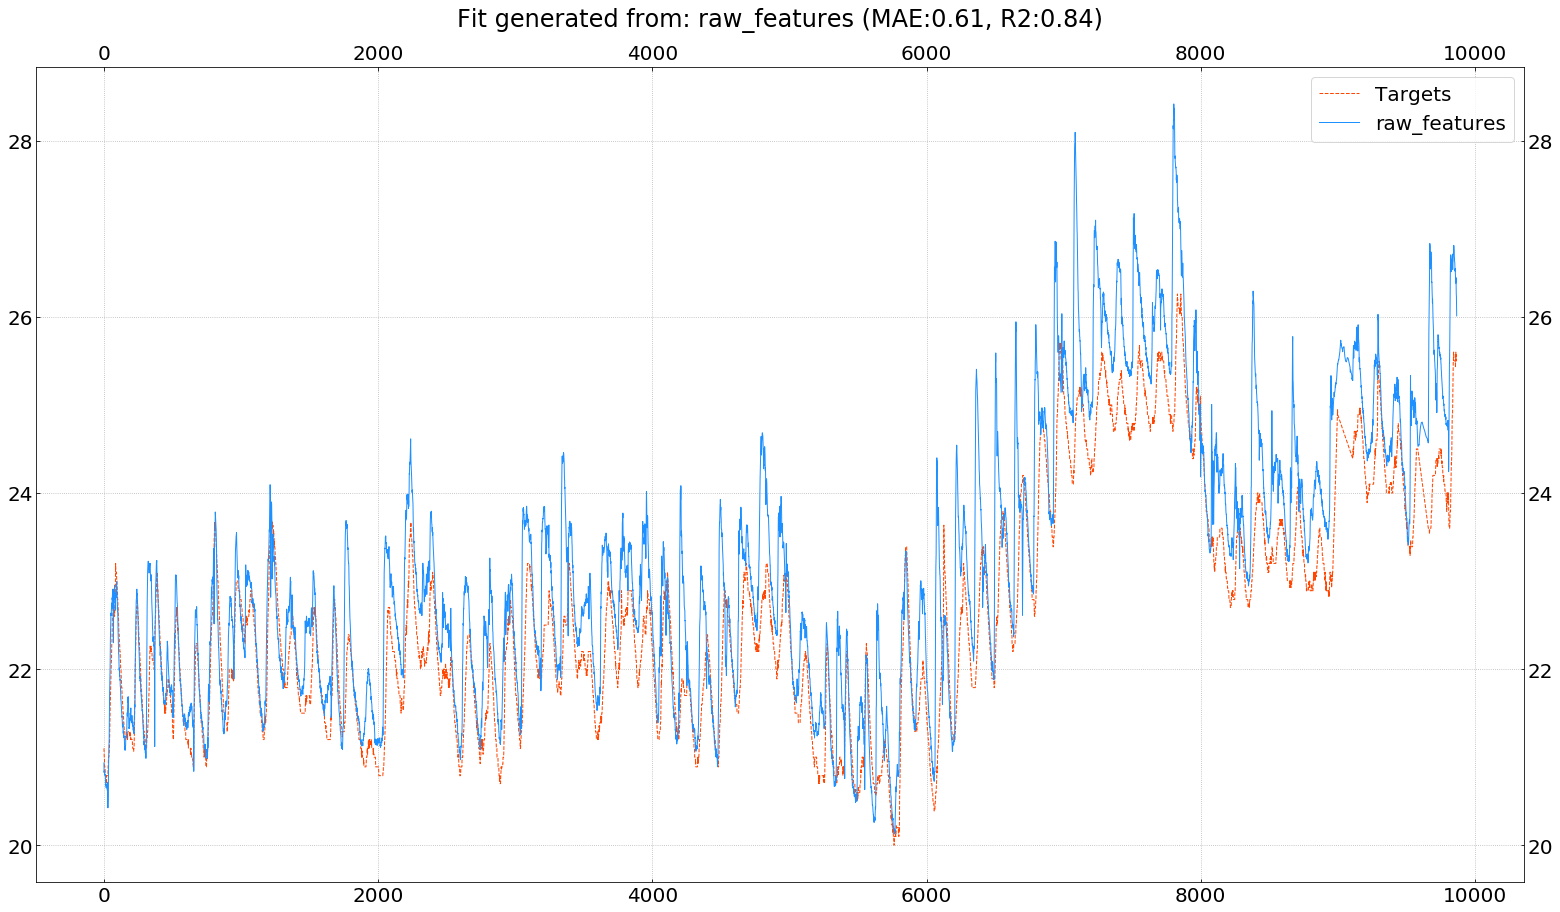

In [25]:
    %matplotlib inline
    plot_fit(
        targets_vector=targets_test,
        predictions_vector=predictions_table['raw_features']
    )

As noted previousley, fit from raw features is really good. MAE is below one degree, and even when there is a shift in distribution, linear regression from raw features, does not loose much of its fit. Let us see how quantile transformer is performing.

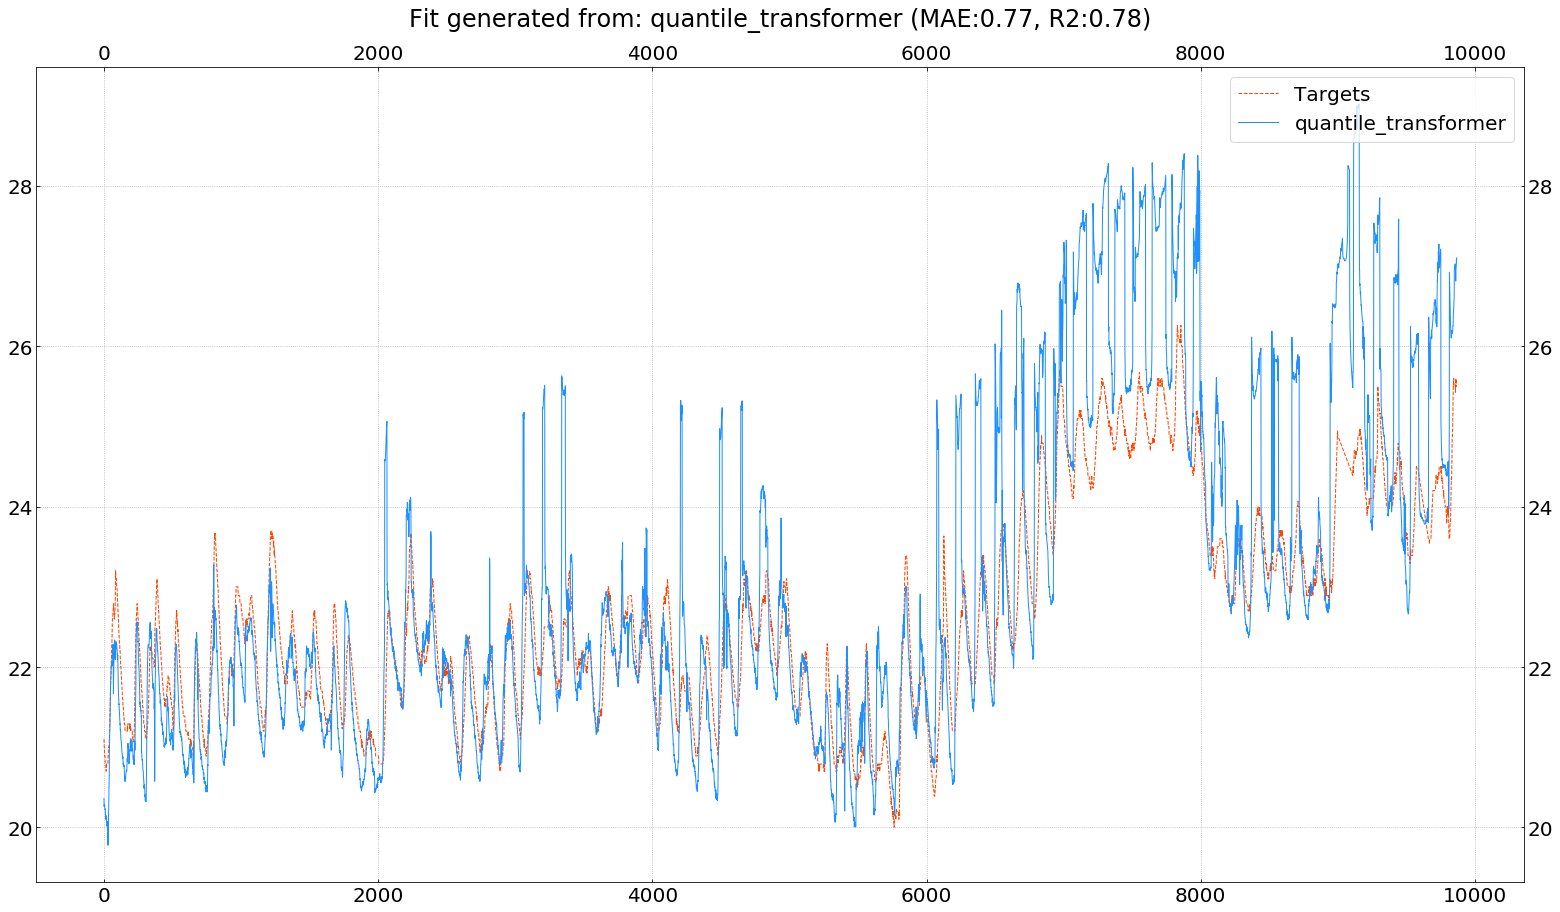

In [26]:
    plot_fit(
        targets_vector=targets_test,
        predictions_vector=predictions_table['quantile_transformer']
    )

Quantile transformation actually deteriorates the fit. MAE as well as quality of the fit is declining. Please not that the original features have not been examined for normality of their distribution, and that there has been no tuning of the quantile transformer. Lets swich to k-bins dihotomization.

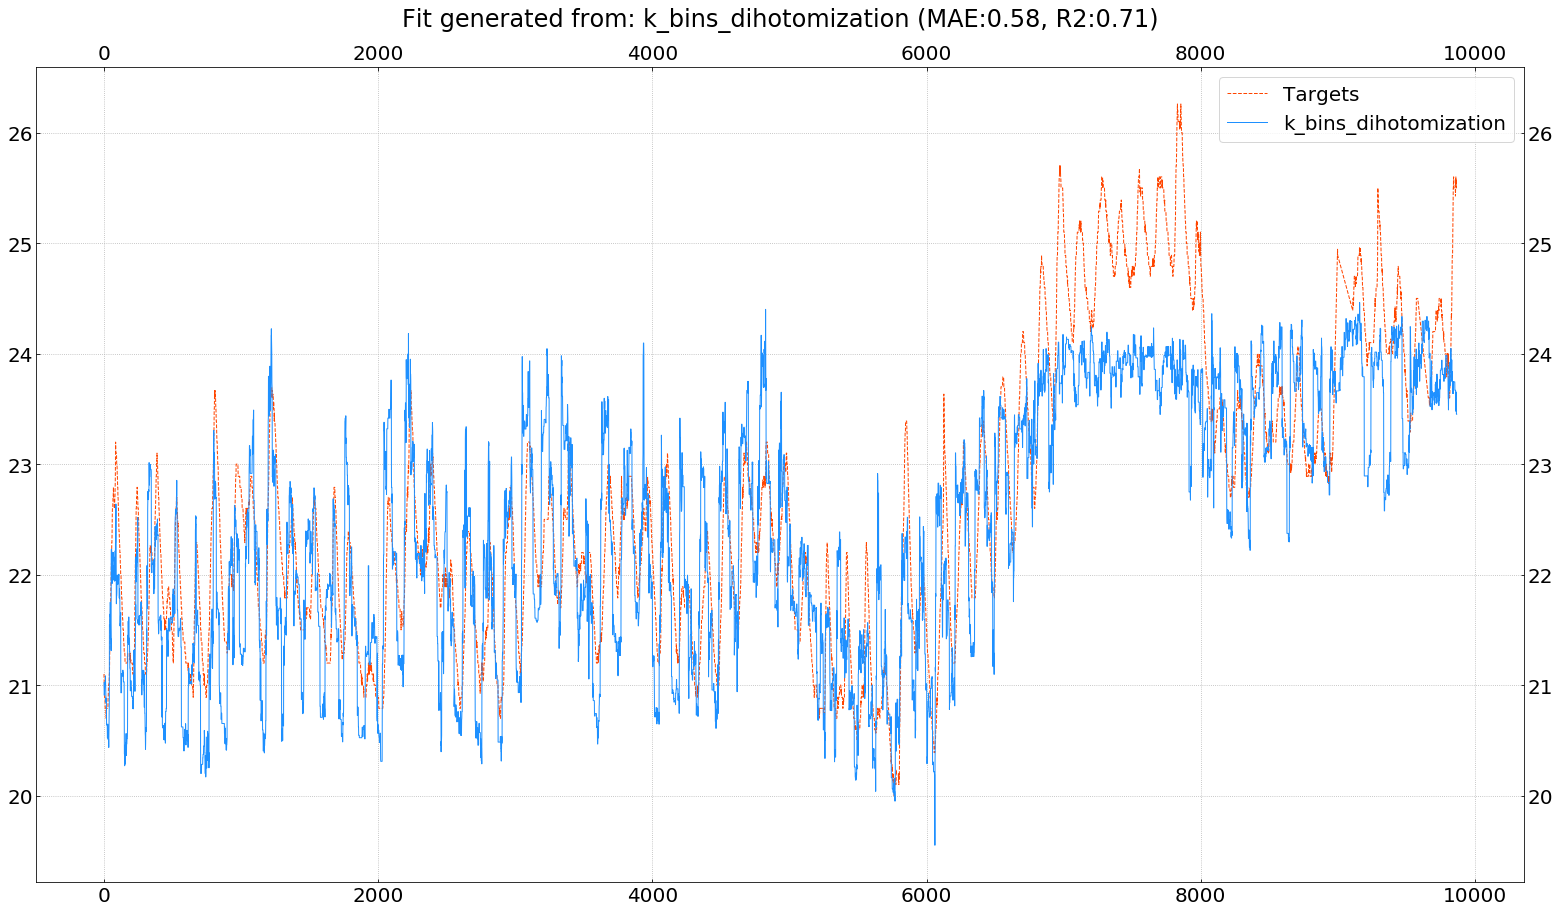

In [27]:
    plot_fit(
        targets_vector=targets_test,
        predictions_vector=predictions_table['k_bins_dihotomization']
    )

K-bins dihotomization gives better accuracy, however fit is compromised especially in the later section of the predictions. It could be argued that at the beginning of the predictions, the fit is even better than the one from the original features. Let us see how PCA feature engineering worked.

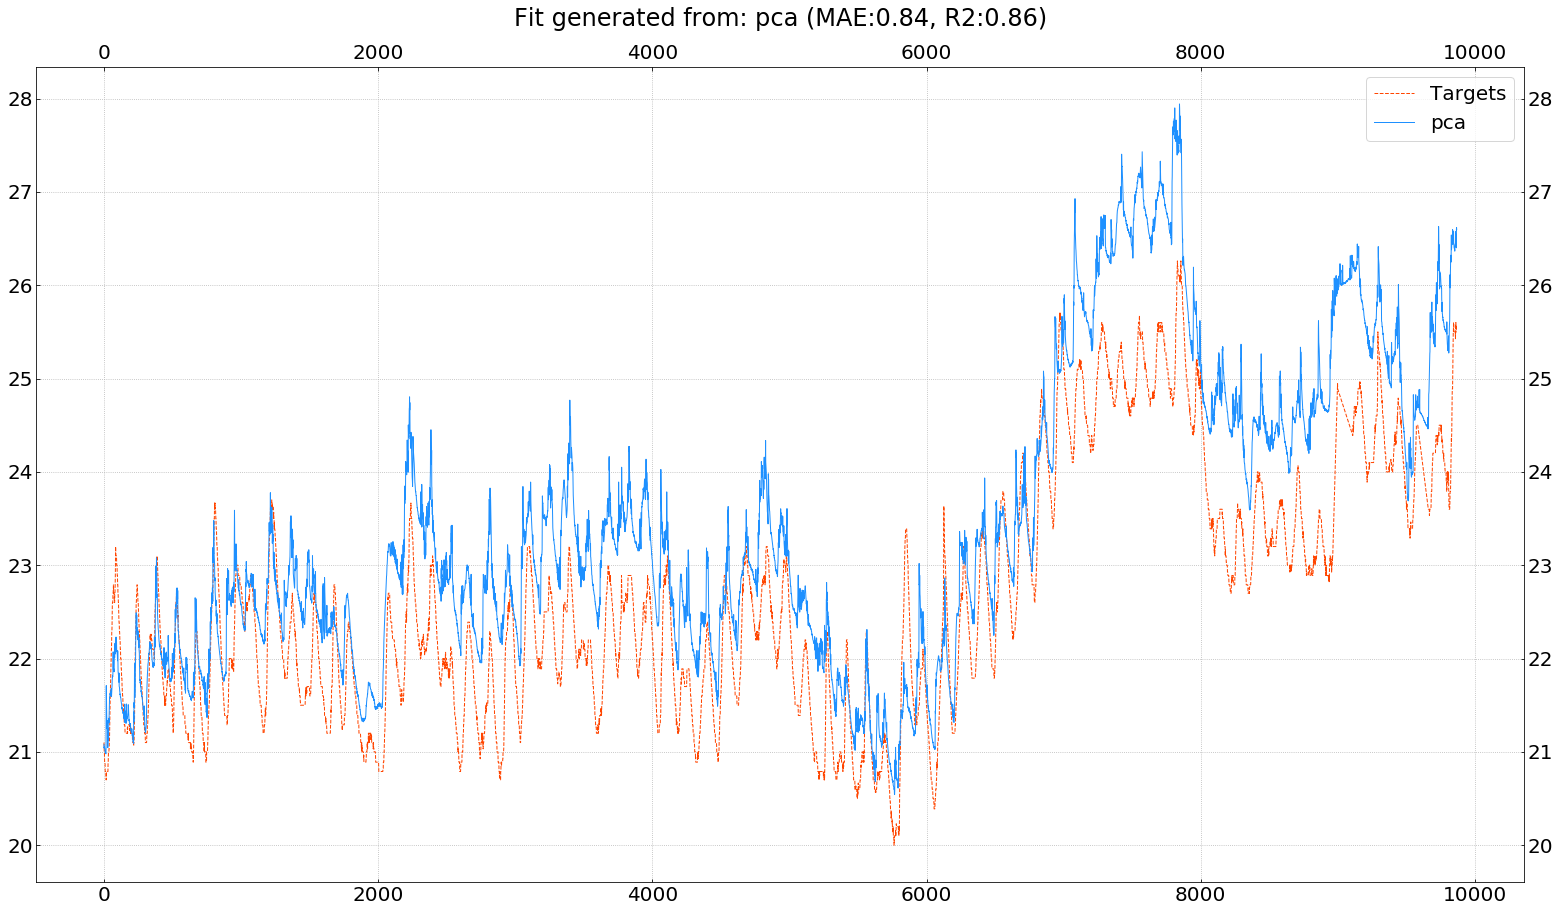

In [28]:
    plot_fit(
        targets_vector=targets_test,
        predictions_vector=predictions_table['pca']
    )

Interestingly, quality of fit of features enginnered from PCA is better than the benchmark, even though overall accuracy is lagging. Finally, we can examine the performance of features engineered with feature agglomeration.

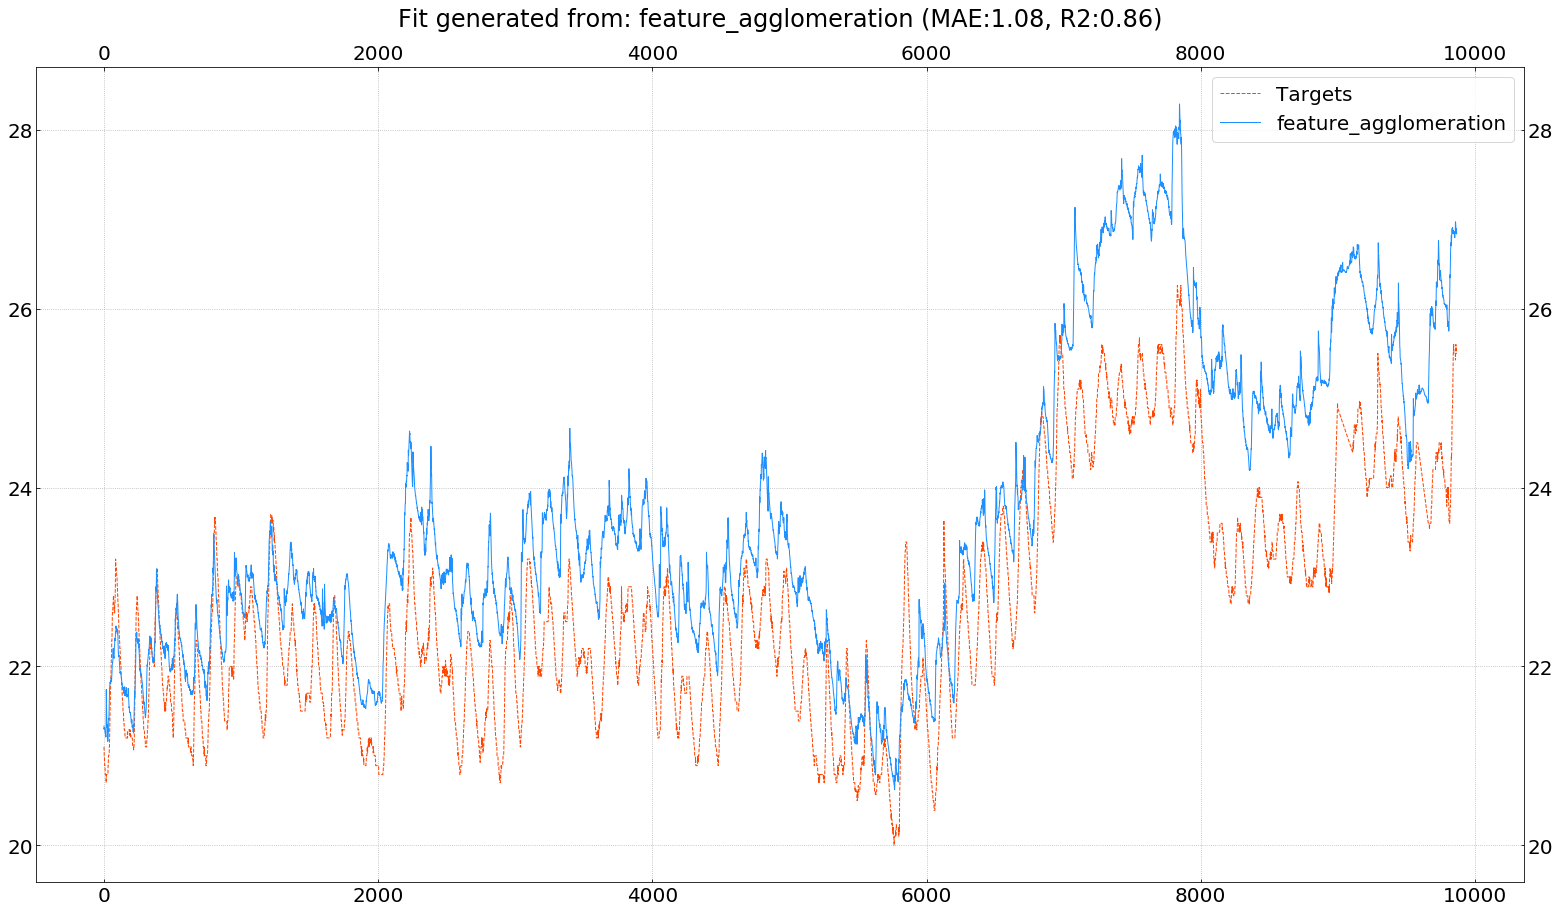

In [29]:
    plot_fit(
        targets_vector=targets_test,
        predictions_vector=predictions_table['feature_agglomeration']
    )

Similar to the PCA, feature agglomeration performs better when it comes to hte quality of fit, and worse when it comes to the accuracy. It seems that there is a better representation of features that better captures the characteristics of the target curve. However, accuracy of model trained on raw features seems hard to beat.

# Conclusion

Previous examples have shown four distinct methods of feature engineering, and explored their influence on quality of fit of regression model generated from these features. Initial model generated from raw features was already a good fit. However, k-bins dihotomozation of features produced higher accuracy, while features engineered from PCA and feature agglomeration produce better quality of fit. Further experimentation is necessary is it possible to find a method, or a combination of feature engineering methods, whcih can achieve improvement of accuracy and quality of fit at the same time.